In [1]:
%load_ext autoreload
%autoreload 2

import sympy as sp
import numpy as np
import matplotlib.pyplot as plt

from mira.metamodel import *
from mira.sources.sympy_ode import template_model_from_sympy_odes
from mira.modeling.amr.petrinet import template_model_to_petrinet_json_file
from mira.modeling import Model
from mira.modeling.ode import OdeModel, simulate_ode_model

In [2]:
# Define time variable
t = sp.symbols("t")


# Define time-dependent variables
(
    susceptible_h,
    susceptible_r,
    exposed_h,
    exposed_r,
    infected_h,
    infected_r,
    quarantined,
    recovered,
) = sp.symbols(
    "susceptible_h susceptible_r exposed_h exposed_r infected_h infected_r quarantined recovered",
    cls=sp.Function,
)

# Define the parameters with spelled-out names
(
    theta_h,
    theta_r,
    beta_1,
    beta_2,
    beta_3,
    alpha_1,
    alpha_2,
    alpha_3,
    phi,
    tau,
    gama,
    mu_h,
    mu_r,
    delta_h,
    delta_r,
) = sp.symbols(
    "theta_h theta_r beta_1 beta_2 beta_3 alpha_1 alpha_2 alpha_3 phi tau gama mu_h mu_r delta_h delta_r"
)

N_h = (
    susceptible_h(t)
    + exposed_h(t)
    + infected_h(t)
    + quarantined(t)
    + recovered(t)
)
N_r = susceptible_r(t) + exposed_r(t) + infected_r(t)

concept_data = {
    "susceptible_h": {
        "identifiers": {"ido": "0000514"},
        "context": {"species": "ncbitaxon:9606"},
    },
    "exposed_h": {
        "identifiers": {"ido": "0000597"},
        "context": {"species": "ncbitaxon:9606"},
    },
    "infected_h": {
        "identifiers": {"ido": "0000511"},
        "context": {"species": "ncbitaxon:9606"},
    },
    "quarantined": {"context": {"species": "ncbitaxon:9606"}},
    "recovered": {
        "identifiers": {"ido": "0000592"},
        "context": {"species": "ncbitaxon:9606"},
    },
    "susceptible_r": {
        "identifiers": {"ido": "0000514"},
        "context": {"species": "ncbitaxon:9989"},
    },
    "exposed_r": {
        "identifiers": {"ido": "0000597"},
        "context": {"species": "ncbitaxon:9989"},
    },
    "infected_r": {
        "identifiers": {"ido": "0000511"},
        "context": {"species": "ncbitaxon:9989"},
    },
}
human_infection_rate = ((beta_1 * infected_r(t) + beta_2 * infected_h(t)) * susceptible_h(t)) / N_h
rat_infection_rate = (beta_3 * susceptible_r(t) * infected_r(t)) / N_r

odes = [
    sp.Eq(
        susceptible_h(t).diff(t),
        theta_h
        - human_infection_rate
        - mu_h * susceptible_h(t)
        + phi * quarantined(t),
    ),
    sp.Eq(
        exposed_h(t).diff(t),
        human_infection_rate - (alpha_1 + alpha_2 + mu_h) * exposed_h(t),
    ),
    sp.Eq(
        infected_h(t).diff(t),
        alpha_1 * exposed_h(t) - (mu_h + delta_h + gama) * infected_h(t),
    ),
    sp.Eq(
        quarantined(t).diff(t),
        alpha_2 * exposed_h(t) - (phi + tau + delta_h + mu_h) * quarantined(t),
    ),
    sp.Eq(
        recovered(t).diff(t),
        gama * infected_h(t) + tau * quarantined(t) - mu_h * recovered(t),
    ),
    sp.Eq(
        susceptible_r(t).diff(t),
        theta_r - rat_infection_rate - mu_r * susceptible_r(t),
    ),
    sp.Eq(
        exposed_r(t).diff(t),
        rat_infection_rate - (mu_r + alpha_3) * exposed_r(t),
    ),
    sp.Eq(
        infected_r(t).diff(t),
        alpha_3 * exposed_r(t) - (mu_r + delta_r) * infected_r(t),
    ),
]


# # "gamma" is a key-word in sympy, opt to use "gama" instead
parameter_data = {
    "theta_h": {"value": 0.029},
    "theta_r": {"value": 0.2},
    "beta_1": {"value": 0.00025},
    "beta_2": {"value": 0.00006},
    "beta_3": {"value": 0.027},
    "alpha_1": {"value": 0.2},
    "alpha_2": {"value": 2.0},
    "alpha_3": {"value": 0.2},
    "phi": {"value": 2.0},
    "tau": {"value": 0.52},
    "gama": {"value": 0.83},
    "mu_h": {"value": 1.5},
    "mu_r": {"value": 0.002},
    "delta_h": {"value": 0.2},
    "delta_r": {"value": 0.5},
}

initials = {
    "susceptible_h": Initial(
        concept=Concept(name="susceptible_h"),
        expression=SympyExprStr(sp.Float(6e7)),
    ),
    "exposed_h": Initial(
        concept=Concept(name="exposed_h"),
        expression=SympyExprStr(sp.Float(2000)),
    ),
    "infected_h": Initial(
        concept=Concept(name="infected_h"),
        expression=SympyExprStr(sp.Float(100)),
    ),
    "quarantined": Initial(
        concept=Concept(name="quarantined"),
        expression=SympyExprStr(sp.Float(10)),
    ),
    "recovered": Initial(
        concept=Concept(name="recovered"), expression=SympyExprStr(sp.Float(0))
    ),
    "susceptible_r": Initial(
        concept=Concept(name="susceptible_r"),
        expression=SympyExprStr(sp.Float(6e5)),
    ),
    "exposed_r": Initial(
        concept=Concept(name="exposed_r"),
        expression=SympyExprStr(sp.Float(800)),
    ),
    "infected_r": Initial(
        concept=Concept(name="infected_r"),
        expression=SympyExprStr(sp.Float(16)),
    ),
}

observables = {
    "all_human_infected": Observable(
        name="all_human_infected",
        expression=SympyExprStr(sp.parse_expr("infected_h")),
    )
}

In [3]:
tm = template_model_from_sympy_odes(
    odes, param_data=parameter_data, concept_data=concept_data
)
tm.initials = initials
tm.observables = observables

In [4]:
template_model_to_petrinet_json_file(tm, 'ModelB_base_petri.json')

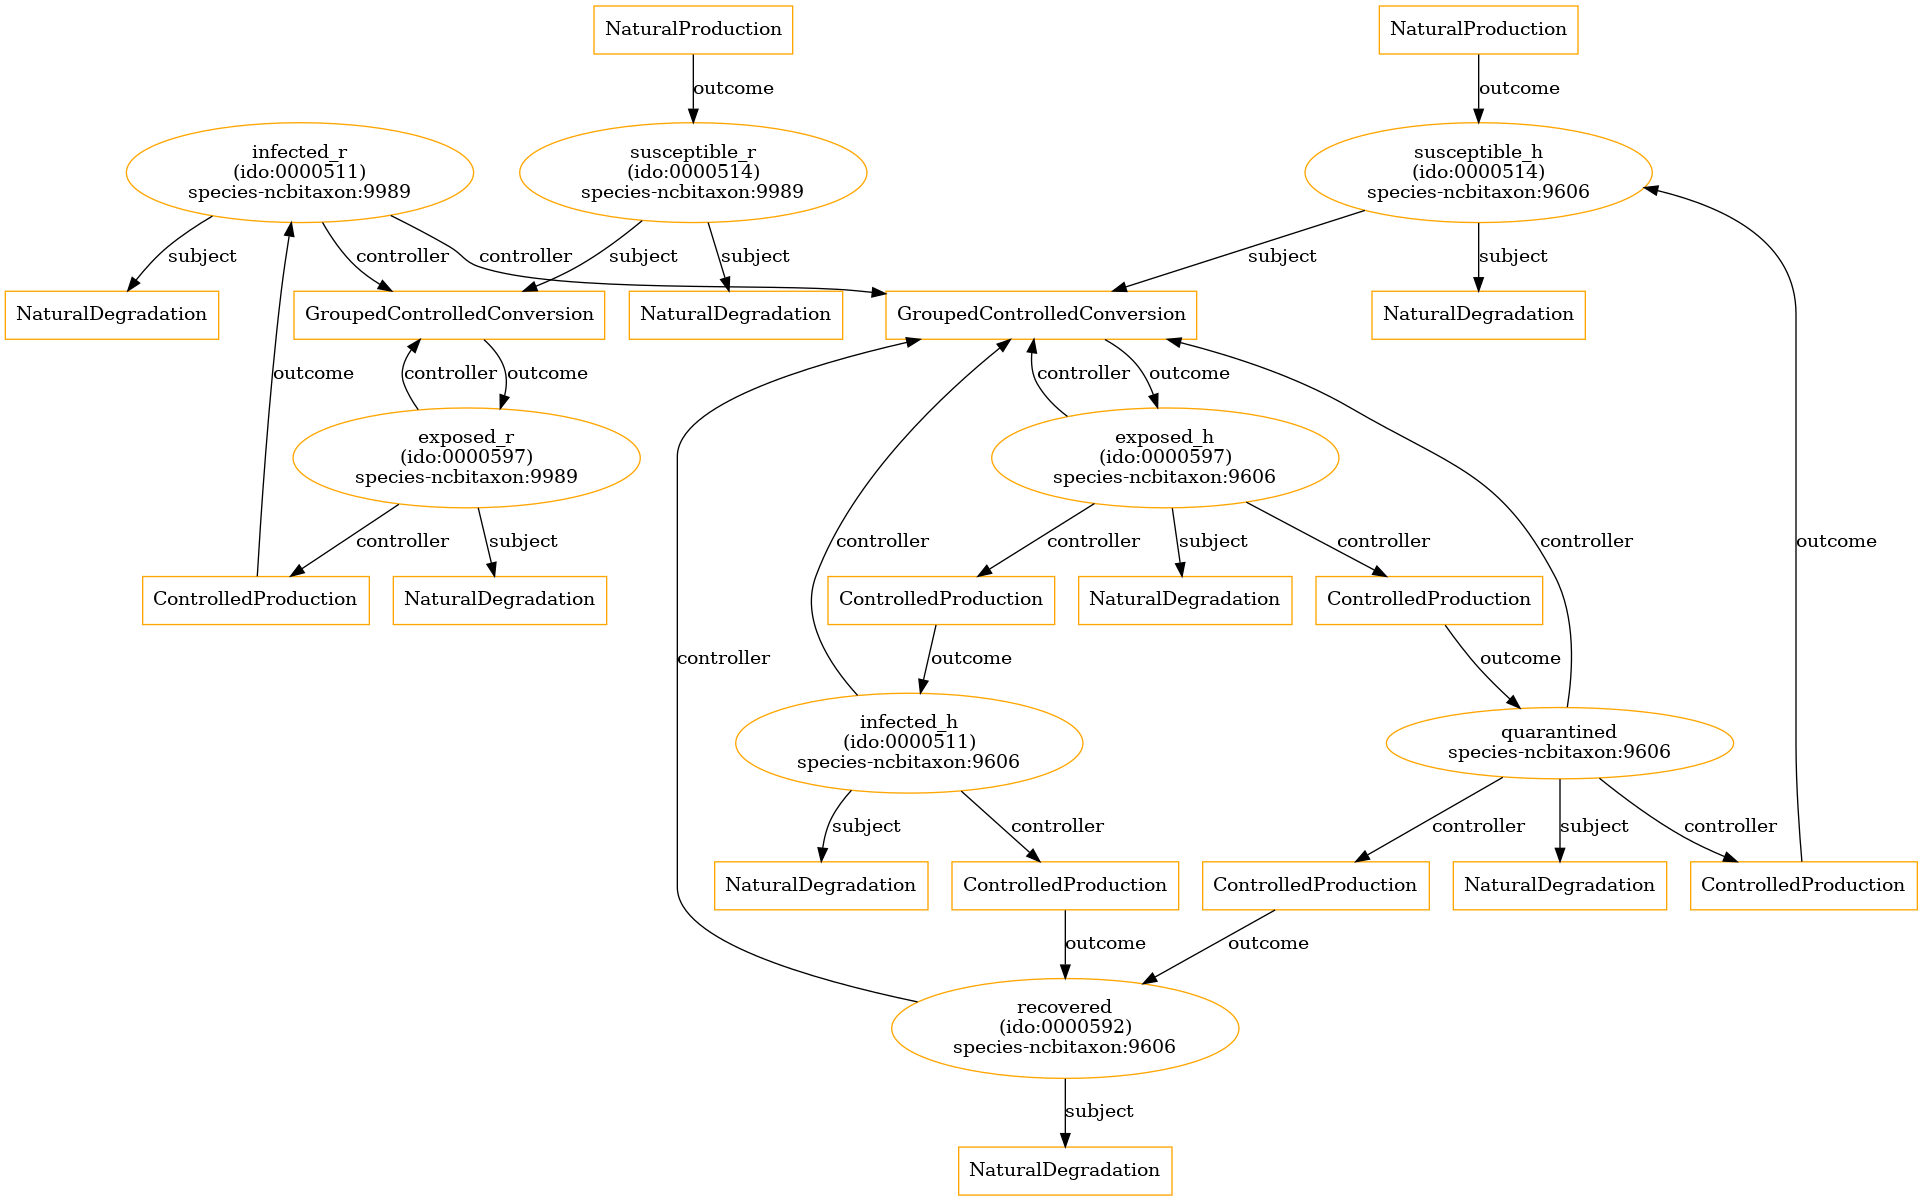

In [5]:
tm.draw_jupyter()

In [6]:
om = OdeModel(Model(tm), initialized=True)

In [7]:
om.get_interpretable_kinetics()

Matrix([
[Derivative(susceptible_h, t), =, -mu_h*susceptible_h + phi*quarantined - susceptible_h*(beta_1*infected_r + beta_2*infected_h)/(exposed_h + infected_h + quarantined + recovered + susceptible_h) + theta_h],
[  Derivative(quarantined, t), =,                                                                                                               alpha_2*exposed_h - quarantined*(delta_h + mu_h + phi + tau)],
[   Derivative(infected_h, t), =,                                                                                                                     alpha_1*exposed_h - infected_h*(delta_h + gama + mu_h)],
[    Derivative(recovered, t), =,                                                                                                                         gama*infected_h - mu_h*recovered + quarantined*tau],
[    Derivative(exposed_h, t), =,           -exposed_h*(alpha_1 + alpha_2 + mu_h) + susceptible_h*(beta_1*infected_r + beta_2*infected_h)/(exposed_h + infected_h +

In [8]:
om.get_interpretable_observables()

Matrix([[all_human_infected, =, infected_h]])

In [9]:
nweeks = 156
times = np.linspace(0, nweeks * 7, nweeks)
res = simulate_ode_model(om, times, with_observables=True)